## Module setup

In [ ]:
import os
import tarfile
import glob
import io
import random
from tqdm import tqdm
import PIL
from IPython.display import display, Image

import numpy as np
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.nn import Parameter
# import torch.nn.functional as F
import torch.optim as optim
import time
# from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms




## Helper 
# RGB -> YCbCr and YCbCr -> RGB image conversion
This part is taken from Kornia
https://kornia.readthedocs.io/en/latest/_modules/kornia/color/ycbcr.html

In [ ]:
def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    """Convert an RGB image to YCbCr.

    Args:
        image (torch.Tensor): RGB Image to be converted to YCbCr with shape :math:`(*, 3, H, W)`.

    Returns:
        torch.Tensor: YCbCr version of the image with shape :math:`(*, 3, H, W)`.

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = rgb_to_ycbcr(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    r: torch.Tensor = image[..., 0, :, :]
    g: torch.Tensor = image[..., 1, :, :]
    b: torch.Tensor = image[..., 2, :, :]

    delta: float = 0.5
    y: torch.Tensor = 0.299 * r + 0.587 * g + 0.114 * b
    cb: torch.Tensor = (b - y) * 0.564 + delta
    cr: torch.Tensor = (r - y) * 0.713 + delta
    return torch.stack([y, cb, cr], -3)



def ycbcr_to_rgb(image: torch.Tensor) -> torch.Tensor:
    """Convert an YCbCr image to RGB.

    The image data is assumed to be in the range of (0, 1).

    Args:
        image (torch.Tensor): YCbCr Image to be converted to RGB with shape :math:`(*, 3, H, W)`.

    Returns:
        torch.Tensor: RGB version of the image with shape :math:`(*, 3, H, W)`.

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = ycbcr_to_rgb(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    y: torch.Tensor = image[..., 0, :, :]
    cb: torch.Tensor = image[..., 1, :, :]
    cr: torch.Tensor = image[..., 2, :, :]

    delta: float = 0.5
    cb_shifted: torch.Tensor = cb - delta
    cr_shifted: torch.Tensor = cr - delta

    r: torch.Tensor = y + 1.403 * cr_shifted
    g: torch.Tensor = y - 0.714 * cr_shifted - 0.344 * cb_shifted
    b: torch.Tensor = y + 1.773 * cb_shifted
    return torch.stack([r, g, b], -3)



class RgbToYcbcr(nn.Module):
    """Convert an image from RGB to YCbCr.

    The image data is assumed to be in the range of (0, 1).

    Returns:
        torch.Tensor: YCbCr version of the image.

    Shape:
        - image: :math:`(*, 3, H, W)`
        - output: :math:`(*, 3, H, W)`

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> ycbcr = RgbToYcbcr()
        >>> output = ycbcr(input)  # 2x3x4x5
    """

    def __init__(self) -> None:
        super(RgbToYcbcr, self).__init__()

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return rgb_to_ycbcr(image)



class YcbcrToRgb(nn.Module):
    """Convert an image from YCbCr to Rgb.

    The image data is assumed to be in the range of (0, 1).

    Returns:
        torch.Tensor: RGB version of the image.

    Shape:
        - image: :math:`(*, 3, H, W)`
        - output: :math:`(*, 3, H, W)`

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> rgb = YcbcrToRgb()
        >>> output = rgb(input)  # 2x3x4x5
    """

    def __init__(self) -> None:
        super(YcbcrToRgb, self).__init__()

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return ycbcr_to_rgb(image)

## Directory setup and preparing the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_dir = '/content/drive/MyDrive/memnet/memnet_ms_t91'
if not os.path.exists(drive_dir):
  os.makedirs(drive_dir)

directory = '/content/memnet'
if not os.path.exists(directory):
  os.makedirs(directory)

os.chdir(directory)
# %mkdir -p /content/drive/MyDrive/memnet
# %cd /content/drive/MyDrive/memnet

In [ ]:
!ls /content/drive/MyDrive/memnet
!cp /content/drive/MyDrive/memnet/t91_crop_training.tar.gz /content/memnet/t91_crop_training.tar.gz
with tarfile.open('t91_crop_training.tar.gz') as archive:
  archive.extractall(directory)

!ls /content/memnet/t91_crop_training/ -1 | wc -l

BSDS300-images.tgz    memnet_ms_bsds  memnet_ss_bsds  t91_crop_training.tar.gz
crop_training.tar.gz  memnet_ms_t91   sample_tests
ls: cannot access '/content/memnet/crop_training/': No such file or directory
0


In [ ]:
# bsds = 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'
# bsds_file = directory+'/bsds300'
# urlretrieve(bsds, bsds_file)
# with tarfile.open(bsds_file) as archive:
#   archive.extractall(directory)

## Model : Multi-Supervised MemNet 

In [ ]:
class FeatExtBlock(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1):
        super(FeatExtBlock, self).__init__()
        self.feature = nn.Sequential(nn.BatchNorm2d(in_channels), nn.ReLU(),
                                     nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                               kernel_size=kernel_size, stride=stride,
                                               padding=padding, bias=False))

    def forward(self, x):
        fe_out = self.feature(x)
        return fe_out

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, n_layers=2, n_channels=32, kernel_size=3, stride=1, padding=1):
    super(ResidualBlock, self).__init__()
    layers = []
    for _ in range(n_layers):
      layers.append(nn.BatchNorm2d(n_channels))
      layers.append(nn.ReLU())
      layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False))
    
    self.residual = nn.Sequential(*layers)

  def forward(self, x):
    out = self.residual(x)
    return out + x

In [ ]:
class RecursiveUnit(nn.Module):
  def __init__(self, n_short=6, d_conv=32):
    super(RecursiveUnit, self).__init__()
    self.n_short = n_short
    self.residual = nn.ModuleList([ResidualBlock(n_layers=2, n_channels=d_conv) for _ in range(n_short)])

  def forward(self, b_prev_m):
    Hs = []
    Hs.append(self.residual[0](b_prev_m))
    for rec in range(1, self.n_short):
      Hs.append(self.residual[rec](Hs[-1]))
    b_short = torch.cat(Hs, dim=1)
    return b_short

In [ ]:
class GateUnit(nn.Module):
    def __init__(self, in_channels, d_conv=32):
        super(GateUnit, self).__init__()
        self.in_channels = in_channels

        
        self.gate_layer = nn.Sequential(nn.BatchNorm2d(in_channels), nn.ReLU(),
                                  nn.Conv2d(in_channels=self.in_channels, out_channels=d_conv, kernel_size=1,
                                            stride=1, padding=0, bias=False))

    def forward(self, b_gate):
        b_mem = self.gate_layer(b_gate)
        return b_mem

In [ ]:
class MemBlock(nn.Module):
  def __init__(self, n_long, N_short=6, d_conv=32):
    super(MemBlock, self).__init__()
    self.n_long = n_long
    self.N_long = N_short
    self.d_conv = d_conv
    self.gate_in = (n_long + N_short) * d_conv
    self.short_unit = RecursiveUnit(N_short, d_conv)
    self.gate = GateUnit(self.gate_in, self.d_conv)

  def forward(self, b_long):
    b_short = self.short_unit(b_long[:, -self.d_conv:, :, :])
    b_gate = torch.cat([b_short, b_long], dim=1)
    b_m = self.gate(b_gate)
    return b_m

In [ ]:
class ReconstBlock(nn.Module):
  def __init__(self, d_conv=32, kernel_size=3, stride=1, padding=1):
    super(ReconstBlock, self).__init__()
    self.d_conv = d_conv
    self.recon = nn.Sequential(nn.BatchNorm2d(d_conv),
                               nn.ReLU(),
                               nn.Conv2d(in_channels=d_conv, out_channels=1, kernel_size=kernel_size,
                                         stride=stride, padding=padding, bias=False))

  def forward(self, b_m, x):
    y = self.recon(b_m)
    return y+x

In [ ]:
class MemNet(nn.Module):
    def __init__(self, N_long, N_short, d_conv=32):
        super(MemNet, self).__init__()
        self.N_long = N_long
        self.N_short = N_short
        self.d_conv = d_conv
        self.fe_block = FeatExtBlock(1, d_conv)
        self.mem_blocks = nn.ModuleList([MemBlock(n_mem+1, N_short, d_conv) for n_mem in range(N_long)])
        self.recon_block = ReconstBlock(d_conv)
        # This part is taken from: https://discuss.pytorch.org/t/contraining-weights-to-sum-to-1/20609/2
        self.eps = 1E-7
        self.linavg = nn.Parameter((1./self.N_long) * torch.ones(N_long), requires_grad=True)

    def forward(self, x):
      fe = self.fe_block(x)
      b_ms = []
      b_ms.append(fe)
      y = torch.zeros_like(x)
      for n_mem in range(self.N_long):
        b_long = torch.cat(b_ms, dim=1)
        b_ms.append(self.mem_blocks[n_mem](b_long))
        # self.linavg = self.linavg.clamp(min=self.eps) # in case weights > 0
        linavg_sum = self.linavg.sum(0, keepdim=True)
        y += self.linavg[n_mem] * self.recon_block(b_ms[-1], x) / linavg_sum

      return y

In [ ]:
def size_check():
  p = torch.rand(2, 1, 4, 4)
  print(p.size())
  d_conv = 8
  fe_model = FeatExtBlock(1, d_conv)
  q = fe_model(p)
  print(q.size())
  mem_model = MemBlock(1, 6, d_conv)
  r = mem_model(q)
  print(r.size())
  recon_model = ReconstBlock(d_conv)
  s = recon_model(r, p)
  print(s.size())
  model = MemNet(2, 2, 32)
  t = model(p)
  print(t.size())

size_check()

torch.Size([2, 1, 4, 4])
torch.Size([2, 8, 4, 4])
torch.Size([2, 8, 4, 4])
torch.Size([2, 1, 4, 4])
torch.Size([2, 1, 4, 4])


## Dataset Preparation

In [ ]:
class DatasetSR(Dataset):
  def __init__(self, images_dir, scale=None, patch_size=None, stride=21, transform=None):
    self.dir = images_dir
    self.files = sorted(glob.glob(images_dir + '/*'))
    self.scale = scale
    self.patch = patch_size
    self.stride = stride
    self.transform=transform
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    image_path = os.path.join(self.dir, self.files[index])

    hr_image = PIL.Image.open(image_path)
    hr_image = hr_image.convert('YCbCr')
    
    random_gen = int(image_path.split('/')[-1].split('_')[-2][-1]) + int(image_path.split('/')[-1].split('_')[-1][-5])
    scale = random_gen % 3 + 2 #random.randint(2, 4)

    width_down = self.patch // scale
    heigth_down = self.patch // scale
    lr_image = hr_image.resize((width_down, heigth_down),
                               resample=PIL.Image.BICUBIC)
    lr_image = lr_image.resize((hr_image.width, hr_image.height),
                               resample=PIL.Image.BICUBIC)
    
    trans_toten = transforms.ToTensor()
    hr_ten = trans_toten(hr_image)
    lr_ten = trans_toten(lr_image)
    hr_ten = rgb_to_ycbcr(hr_ten)
    lr_ten = rgb_to_ycbcr(lr_ten)
    
    if self.transform:
            hr = self.transform(hr_image)
            lr = self.transform(lr_image)

    return hr, lr

## Training

In [ ]:
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
    super(AttrDict, self).__init__(*args, **kwargs)
    self.__dict__ = self

def weights_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data, gain=1.0)
    # nn.init.zeros_(m.bias.data)

# The following function si taken from: https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61
def load_ckp(checkpoint_fpath, model):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint)
    # optimizer.load_state_dict(checkpoint['optimizer'])
    return model

def train(args):
  model = MemNet(args.N_long, args.N_short, args.d_conv)
  model.train()
  if torch.cuda.is_available():
    model = model.cuda()
  
  # optimizer = optim.Adam(model.parameters(), lr=args.lr)
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.w_decay)
  if args['start_from']:
    print('starting from ')
    model = load_ckp(args['start_from'], model)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epochs//4, gamma=0.1)
  criterion = nn.MSELoss()
  # model.apply(weights_init)
  trnsfrm = transforms.Compose([transforms.ToTensor()])
  # dataset = Dataset(opt.images_dir, opt.patch_size, opt.jpeg_quality, opt.use_fast_loader)
  dataset = DatasetSR(images_dir=args.train_dir, scale=args.scale, patch_size=args.patch_size, transform=trnsfrm)
  dataloader = DataLoader(dataset=dataset,
                          batch_size=args.batch_size,
                          shuffle=True,
                          num_workers=args.threads,
                          pin_memory=True,
                          drop_last=False)
  
  print('Training starts...')
  start = time.time()
  train_losses = []
  valid_losses = []
  for epoch in range(args.epochs):
    losses = []
    for i, data in enumerate(dataloader):
      y, x = data
      x = x[:, 0, :, :].unsqueeze(1)
      y = y[:, 0, :, :].unsqueeze(1)
      if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
      
      x_hat = model(x)

      loss = 0.5*args.patch_size*criterion(x_hat, y)
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), args.clip) 
      optimizer.step()
      losses.append(loss.data.item())

    scheduler.step()
    avg_loss = np.mean(losses)
    train_losses.append(avg_loss)
    time_elapsed = time.time() - start
    print('Epoch [%d/%d], Loss: %.4f, Time (s): %d'
          % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )
    if epoch % 1 == 0:
      torch.save(model.state_dict(), os.path.join(args.output_dir, 'memnet_epoch_{}.pth'.format(epoch)))

  # Plot training curve
  plt.figure()
  plt.plot(train_losses, "ro-", label="Train")
  # plt.plot(valid_losses, "go-", label="Validation")
  plt.legend()
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.show()
  plt.savefig(args.output_dir + "train_loss.png")
  
  return model

starting from 
Training starts...
Epoch [1/40], Loss: 0.0296, Time (s): 53
Epoch [2/40], Loss: 0.0285, Time (s): 106
Epoch [3/40], Loss: 0.0280, Time (s): 158
Epoch [4/40], Loss: 0.0275, Time (s): 211
Epoch [5/40], Loss: 0.0274, Time (s): 264
Epoch [6/40], Loss: 0.0269, Time (s): 317
Epoch [7/40], Loss: 0.0264, Time (s): 370
Epoch [8/40], Loss: 0.0261, Time (s): 423
Epoch [9/40], Loss: 0.0260, Time (s): 476
Epoch [10/40], Loss: 0.0258, Time (s): 529
Epoch [11/40], Loss: 0.0241, Time (s): 582
Epoch [12/40], Loss: 0.0233, Time (s): 635
Epoch [13/40], Loss: 0.0229, Time (s): 688
Epoch [14/40], Loss: 0.0226, Time (s): 741
Epoch [15/40], Loss: 0.0223, Time (s): 794
Epoch [16/40], Loss: 0.0220, Time (s): 847
Epoch [17/40], Loss: 0.0218, Time (s): 900
Epoch [18/40], Loss: 0.0216, Time (s): 953
Epoch [19/40], Loss: 0.0214, Time (s): 1006
Epoch [20/40], Loss: 0.0211, Time (s): 1059
Epoch [21/40], Loss: 0.0207, Time (s): 1112
Epoch [22/40], Loss: 0.0206, Time (s): 1165
Epoch [23/40], Loss: 0.020

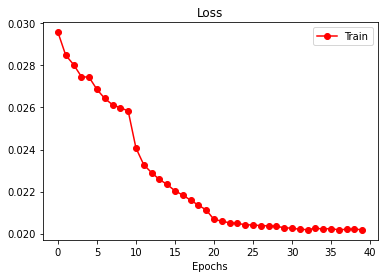

<Figure size 432x288 with 0 Axes>

In [ ]:
args = AttrDict()
args_dict = {
    'threads' : 1,
    'kernel_size' : 3,
    'N_long' : 6,
    'N_short' : 6,
    'd_conv' : 64,
    'lr' : 0.05,
    'momentum' : 0.9,
    'w_decay' : 1E-4,
    'clip' : 0.4,
    'batch_size': 64,
    'patch_size': 31,
    'scale' : 2,
    'epochs' : 40,
    'train_dir' : directory + '/t91_crop_training/',
    'output_dir' : drive_dir,
    'start_from' : '/content/drive/MyDrive/memnet/memnet_ms_bsds/memnet_epoch_79.pth' # default is ''
}
args.update(args_dict)
memnet = train(args)

## Testing

In [ ]:
# args = AttrDict()
# args_dict = {
#     'threads' : 1,
#     'kernel_size' : 3,
#     'N_long' : 6,
#     'N_short' : 6,
#     'd_conv' : 64,
#     'lr' : 0.1,
#     'batch_size': 32,
#     'patch_size': 41,
#     'scale' : 2,
#     'epochs' : 20,
#     'train_dir' : directory + '/BSDS300/images/train/',
#     'output_dir' : '/content/drive/MyDrive/memnet/'
# }
model = MemNet(args_dict['N_long'], args_dict['N_short'], args_dict['d_conv'])
model.load_state_dict(torch.load(os.path.join(args_dict['output_dir'], 'memnet_epoch_{}.pth'.format(3)),
                                 map_location=torch.device('cpu')))

model.eval()
model.requires_grad_ = False
for param in model.parameters():
    param.require_grads = False

In [ ]:
crop_size = 200
down_sample = 3
files = sorted(glob.glob(directory + '/BSDS300/images/train/' + '/*'))
index = random.randint(0,199)
hr_image = PIL.Image.open(files[index])
crop_bl = [100, 100]#[random.randint(0, hr_image.width - crop_size),
           #random.randint(0, hr_image.height - crop_size)]
hr_image = hr_image.crop((crop_bl[0], crop_bl[1],
                          crop_bl[0]+crop_size, crop_bl[1]+crop_size))
lr_width = hr_image.width // down_sample
lr_height = hr_image.height // down_sample
lr_image = hr_image.resize((lr_width, lr_height),
                              resample=PIL.Image.BICUBIC, box=None, reducing_gap=None)
lr_image = lr_image.resize((hr_image.width, hr_image.height),
                              resample=PIL.Image.BICUBIC, box=None, reducing_gap=None)

trsfm = transforms.Compose([transforms.ToTensor()])
lr_ten = trsfm(lr_image)
lr_ten = rgb_to_ycbcr(lr_ten)

pred_c = model(lr_ten.unsqueeze(0)[:, 0, :, :].unsqueeze(1))
# diff = pred_c - lr_ten.unsqueeze(0)[:, 0, :, :].unsqueeze(1)
pred_c = pred_c.detach()
pred_ten = lr_ten.detach().clone()
pred_ten[0, :, :] = pred_c[0, 0, :, :]
pred_ten = pred_ten.detach()

pred_arr = ((255.0*ycbcr_to_rgb(pred_ten)).numpy().astype(np.uint8())).transpose([1, 2, 0])
pred_image = PIL.Image.fromarray(pred_arr, 'RGB')
display(hr_image)
display(lr_image)
display(pred_image)

hr_ten = trsfm(hr_image)
hr_ten = rgb_to_ycbcr(hr_ten)
hr_bl_arr = ((255.0*hr_ten).numpy().astype(np.uint8())).transpose([1, 2, 0])
lr_bl_arr = ((255.0*lr_ten).numpy().astype(np.uint8())).transpose([1, 2, 0])
hr_bl_image = PIL.Image.fromarray(hr_bl_arr[:, :, 0], 'L')
lr_bl_image = PIL.Image.fromarray(lr_bl_arr[:, :, 0], 'L')
display(hr_bl_image)
display(lr_bl_image)

pred_bl_arr = (255.0*pred_c.squeeze()).numpy().astype(np.uint8())
pred_bl_image = PIL.Image.fromarray(pred_bl_arr, 'L')
display(pred_bl_image)

In [ ]:
hr_image = PIL.Image.open('/content/drive/MyDrive/memnet/sample_tests/IMG-4035.JPG')
en_width = int(1.5 * hr_image.width)
en_height = int(1.5 * hr_image.height)
en_image = hr_image.resize((en_width, en_height),
                              resample=PIL.Image.BICUBIC, box=None, reducing_gap=None)

trsfm = transforms.Compose([transforms.ToTensor()])
en_ten = trsfm(en_image)
en_ten = rgb_to_ycbcr(en_ten)

pred_c = model(en_ten.unsqueeze(0)[:, 0, :, :].unsqueeze(1))
pred_c = pred_c.detach()
pred_ten = en_ten.detach().clone()
pred_ten[0, :, :] = pred_c[0, 0, :, :]
pred_ten = pred_ten.detach()

pred_arr_cv = cv2.normalize((ycbcr_to_rgb(pred_ten).squeeze()).numpy().transpose([1, 2, 0]),
                            None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
pred_arr = ((255.0*ycbcr_to_rgb(pred_ten)).numpy().astype(np.uint8())).transpose([1, 2, 0])
pred_image = PIL.Image.fromarray(pred_arr, 'RGB')
pred_image_cv = PIL.Image.fromarray(pred_arr_cv, 'RGB')
display(hr_image.transpose(PIL.Image.ROTATE_270))
display(en_image.transpose(PIL.Image.ROTATE_270))
display(pred_image.transpose(PIL.Image.ROTATE_270))
display(pred_image_cv.transpose(PIL.Image.ROTATE_270))